# Importation des bibliothèques nécessaires

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import seaborn as sn
from sklearn.model_selection import train_test_split

# Chargements des données

In [52]:
# Constants
IMG_SIZE = 128
BATCH_SIZE = 32

# Fonction pour charger les données
def load_data():
    """Charge les données de malaria depuis tensorflow_datasets"""
    dataset_name = "malaria"
    (train_data, test_data), metadata = tfds.load(
        dataset_name,
        split=["train[:80%]", "train[80%:]"],
        as_supervised=True,
        with_info=True
    )
    return train_data, test_data, metadata

# Charger le dataset avec metadata
(train_dataset, test_dataset, info) = load_data()

# Calculer le nombre d'exemples pour le split
num_train_examples = int(info.splits['train'].num_examples * 0.8)
num_validation_examples = int(info.splits['train'].num_examples * 0.2)

print("Dataset Info:")
print(info)
print(f"Nombre d'exemples dans le dataset d'entraînement: {num_train_examples}")
print(f"Nombre d'exemples dans le dataset de validation: {num_validation_examples}")

Dataset Info:
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Utilisateur\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria paras

# Préparation des données

Visualisation des exemples du dataset d'entraînement:


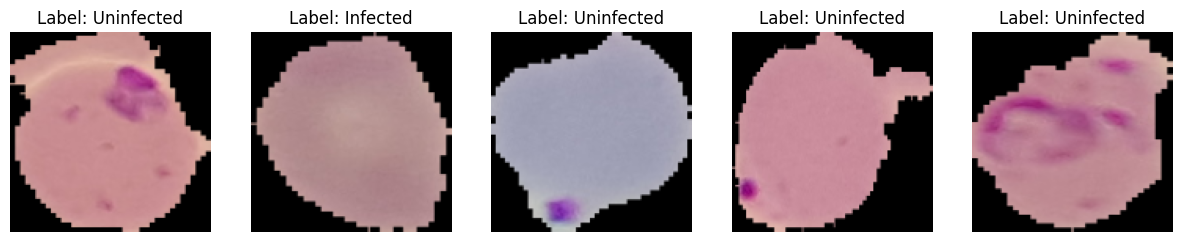

In [53]:
# Prétraitement des données
def preprocess(image, label):
    """Redimensionne et normalise les images"""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalisation entre 0 et 1
    return image, label

train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE)

# Visualisation de quelques exemples
def visualize_data(dataset, num_images=5):
    """Affiche quelques exemples du dataset"""
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Label: {'Infected' if label.numpy() == 1 else 'Uninfected'}")
        plt.axis('off')
    plt.show()

print("Visualisation des exemples du dataset d'entraînement:")
visualize_data(train_dataset.unbatch())

# Construction et compilation du modèle

In [66]:

# Créer le modèle CNN
model = tf.keras.Sequential([
tf.keras.Input(shape=(128, 128, 3)),  # Taille de l'image 128x128 avec 3 canaux couleur (RGB)
tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # Première couche convolutionnelle
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling pour réduire la taille de l'image

tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Deuxième couche convolutionnelle
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling pour réduire la taille de l'image

tf.keras.layers.Flatten(),  # Flatten pour transformer les données en vecteur
tf.keras.layers.Dropout(0.7),  # Dropout pour éviter le surapprentissage

tf.keras.layers.Dense(128, activation='relu'),  # Couche dense avec activation ReLU
tf.keras.layers.Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
    ])

    # Compiler le modèle
model.compile(optimizer='adam',  # Optimiseur Adam
            loss='binary_crossentropy',  # Fonction de perte pour une classification binaire
            metrics=['accuracy', 'precision', 'recall'])  # Métriques à surveiller


# Afficher le résumé du modèle
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement du modèle

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 247s 351ms/step - accuracy: 0.6283 - loss: 0.6436 - precision: 0.6125 - recall: 0.7001 - val_accuracy: 0.8930 - val_loss: 0.3848 - val_precision: 0.9386 - val_recall: 0.8389
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 236s 337ms/step - accuracy: 0.9113 - loss: 0.2568 - precision: 0.8854 - recall: 0.9442 - val_accuracy: 0.9296 - val_loss: 0.2038 - val_precision: 0.8981 - val_recall: 0.9678
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 245s 349ms/step - accuracy: 0.9311 - loss: 0.1990 - precision: 0.9145 - recall: 0.9499 - val_accuracy: 0.9229 - val_loss: 0.2275 - val_precision: 0.8816 - val_recall: 0.9755
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 260s 371ms/step - accuracy: 0.9379 - loss: 0.1889 - precision: 0.9178 - recall: 0.9611 - val_accuracy: 0.9345 - val_loss: 0.2063 - val_precision: 0.9042 - val_recall: 0.9707
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 250s 356ms/step - accuracy: 0.9432 - loss: 0.1695 - precision: 0.9288 - recall: 0.9601 - val_accuracy: 0

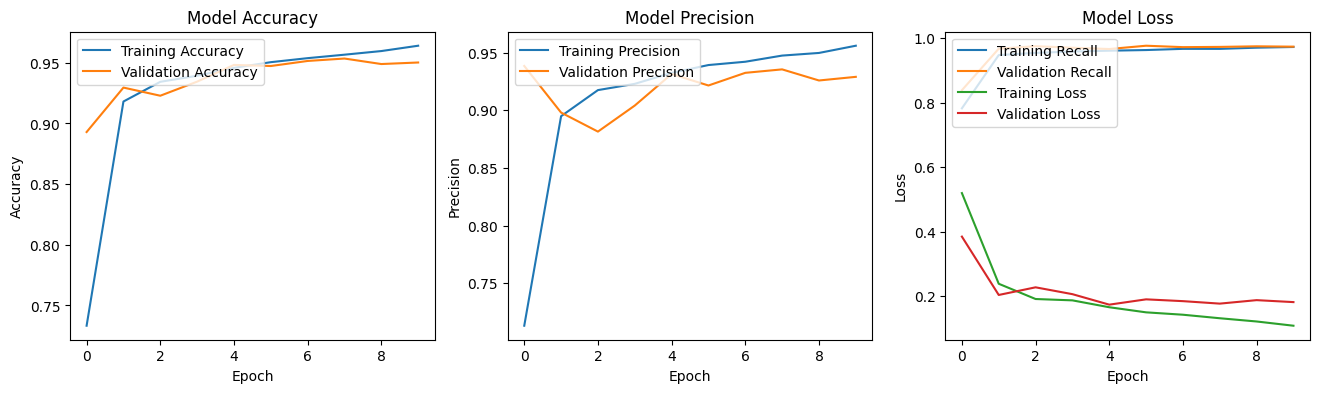

In [ ]:
# Préparer les données
train_dataset, validation_dataset = train_dataset, test_dataset

# Entraîner le modèle
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Visualiser l'évolution des performances
plt.figure(figsize=(16, 4))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Precision
plt.subplot(1, 3, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 250s 348ms/step - accuracy: 0.5902 - loss: 0.7006 - precision: 0.5861 - recall: 0.6332 - val_accuracy: 0.9153 - val_loss: 0.2581 - val_precision: 0.8791 - val_recall: 0.9612
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 246s 350ms/step - accuracy: 0.9226 - loss: 0.2397 - precision: 0.9057 - recall: 0.9443 - val_accuracy: 0.9240 - val_loss: 0.2471 - val_precision: 0.8838 - val_recall: 0.9747
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 266s 380ms/step - accuracy: 0.9371 - loss: 0.1876 - precision: 0.9277 - recall: 0.9491 - val_accuracy: 0.9331 - val_loss: 0.2091 - val_precision: 0.9039 - val_recall: 0.9678
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 304s 433ms/step - accuracy: 0.9426 - loss: 0.1675 - precision: 0.9368 - recall: 0.9494 - val_accuracy: 0.9389 - val_loss: 0.1895 - val_precision: 0.9148 - val_recall: 0.9667
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 272s 388ms/step - accuracy: 0.9459 - loss: 0.1573 - precision: 0.9363 - recall: 0.9579 - val_accuracy: 0

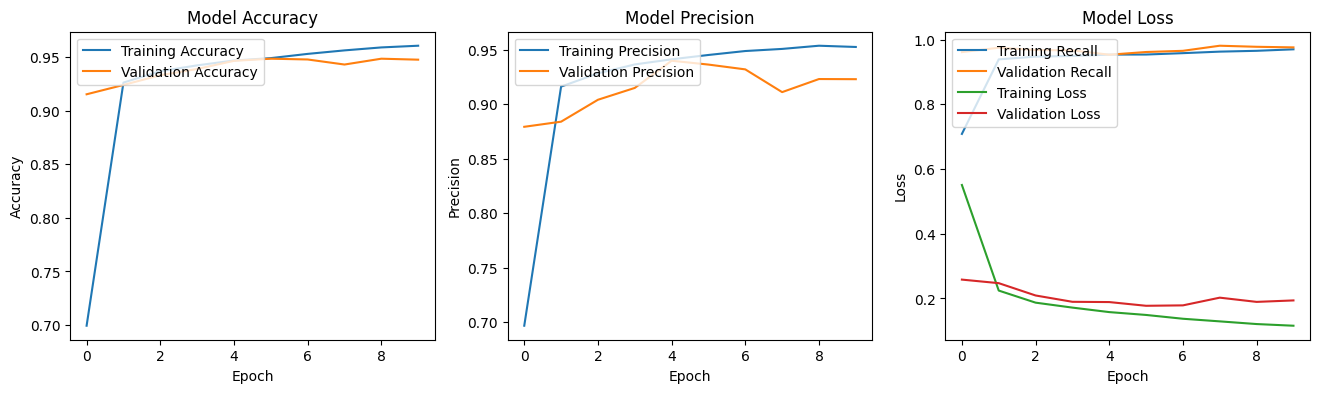

In [75]:
# Préparer les données
train_dataset, validation_dataset = train_dataset, test_dataset

# Entraîner le modèle
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Sauvegarder le modèle après l'entraînement
model.save("/app/model/malaria_model.h5")

# Visualiser l'évolution des performances
plt.figure(figsize=(16, 4))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Precision
plt.subplot(1, 3, 2)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [80]:
import keras.saving

keras.saving.save_model(model, "/app/model/malaria_model.keras")

# Visualisations de quelques prédictions

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

# Charger le modèle Keras
model = tf.keras.models.load_model("app/model/malaria_model.h5")

# Prédire les étiquettes sur le jeu de test
test_dataset, test_labels = next(iter(test_dataset)), next(iter(test_labels))
predictions = model.predict(test_dataset)

# Convertir les prédictions en étiquette binaire (0 ou 1)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)

# Afficher la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Infected'], yticklabels=['Uninfected', 'Infected'])
plt.xlabel('Préditions')
plt.ylabel('Réels')
plt.title('Matrice de confusion')
plt.show()
